In [1]:
from warnings import simplefilter
from joblib import parallel_backend
# ignore all warnings
simplefilter(action='ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,confusion_matrix,classification_report,precision_score,recall_score,f1_score, roc_auc_score, log_loss
import time
import cuml
data = pd.read_csv("./archive/data/creditcard_csv.csv", true_values=["'1'"], false_values=["'0'"])
from imblearn import over_sampling, under_sampling
from sklearn.model_selection import GridSearchCV

In [2]:
def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
      #0 is False, 1 is True
    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
           FP += 1
        if y_actual[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
           FN += 1

    return (TP, FP, TN, FN)

In [3]:
def train_test_model(model,X_train,y_train,X_val,y_val, title = '_norm_'):
    # tic = time.time()
    model.fit(X_train,y_train)
    # toc = time.time()
    
    predictions = model.predict(X_val)
    # cm = confusion_matrix(y_pred=predictions, y_true=y_val)
    # FP = cm.sum(axis=0) - np.diag(cm)  
    # FN = cm.sum(axis=1) - np.diag(cm)
    # TP = np.diag(cm)
    # TN = cm.sum() - (FP + FN + TP)
    TP, FP, TN, FN = perf_measure(y_val, predictions)

    # Sensitivity, hit rate, recall, or true positive rate
    # TPR = TP/(TP+FN)
    # Specificity or true negative rate
    try:
        TNR = TN/(TN+FP) 
    except:
        TNR = -100
    # Precision or positive predictive value
    try:
        PPV = TP/(TP+FP)
    except:
        PPV = -100    
    
    # Negative predictive value
    try:
        NPV = TN/(TN+FN)
    except:
        NPV = -100
    # Fall out or false positive rate
    try:
        FPR = FP/(FP+TN)
    except:
        FPR = -100
    # False negative rate
    try:
        FNR = FN/(TP+FN)
    except:
        FNR = -100
    # False discovery rate
    try:
        FDR = FP/(TP+FP)
    except:
        FDR = -100
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    # time_taken = toc-tic
    accuracy = np.round(accuracy_score(y_val,predictions), 3)
    precision = np.round(precision_score(y_val,predictions), 3)
    recall = np.round(recall_score(y_val,predictions), 3)
    f1 = np.round(f1_score(y_val,predictions), 3)
    logl = np.round(log_loss(y_val, predictions), 3)
    # print('Time taken: ',time_taken)
    print('Test size:',len(y_val))
    print('Model Accuracy: ',accuracy)
    print('Total Precision: ',precision)
    print('Total Recall: ',recall)
    print('Total F1 Score: ',f1)
    # print('Benchmark: \% of fraudulent detections',np.count_nonzero(predictions)/492)
    # print("Classification Report:\n")
    # print(classification_report(y_val,predictions))
    # print("Area under ROC curve: ", roc_auc_score(y_val, predictions))
    print("Log loss: ", logl)
    print("Confusion Matrix:\n")
    ConfusionMatrixDisplay.from_estimator(model,X_val,y_val, colorbar=False)
    plt.savefig(title + '_CF.png')
    plt.show()
    return [accuracy, PPV, recall, NPV, FPR, TNR, FNR, FDR, f1, logl]
    # print("ROC curve:\n")
    # RocCurveDisplay.from_estimator(model,X_val,y_val)
    # plt.show()

In [4]:
labels = np.float64(data['Class'].values)
features = data.drop("Class", axis=1).to_numpy()

train_features,  temp_features, train_labels, temp_labels = train_test_split(features, labels, train_size=0.7)

val_features, test_features, val_labels, test_labels = train_test_split(temp_features, temp_labels, train_size=0.5)

### Final: Cross-validation to find the best (model+ best sampling technique) + test set evaluation

Test size: 42721
Model Accuracy:  0.998
Total Precision:  1.0
Total Recall:  0.051
Total F1 Score:  0.098
Log loss:  0.062
Confusion Matrix:



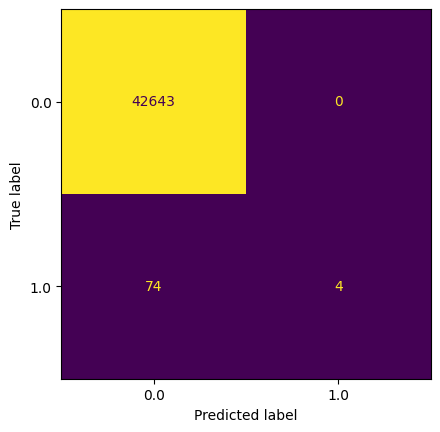

In [5]:
#SVM
base_svc = cuml.svm.SVC(tol=0.01)
param_grid = {
    'kernel':['linear','rbf'],
    'C':[0.01,1,10,100],
    'gamma':['auto','scale']
}
grid_model_1 = GridSearchCV(base_svc,param_grid)
svc = train_test_model(grid_model_1,train_features,train_labels,val_features,val_labels, title = './outputs/SVM/SVM_CV')

Fitting 2 folds for each of 75 candidates, totalling 150 fits
[W] [21:48:13.714630] QWL-QN: max iterations reached
[W] [21:48:13.714739] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [21:48:20.308274] QWL-QN: max iterations reached
[W] [21:48:20.308396] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [21:48:22.931701] QWL-QN: max iterations reached
[W] [21:48:22.931802] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [21:49:01.709658] QWL-QN: max iterations reached
[W] [21:49:01.709765] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the numb

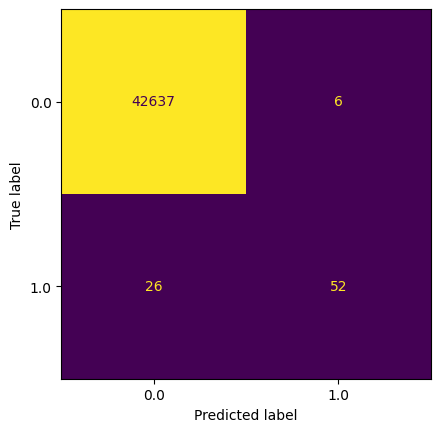

In [6]:
#LGR
base_lgr = cuml.LogisticRegression()
param_grid = {
    'penalty':['l1','l2','elasticnet'],
    'l1_ratio':np.linspace(0,1,5),
    'C':np.logspace(0,10,5)
}   

grid_model_2 = GridSearchCV(base_lgr,param_grid, verbose=1, cv=2)
lgr = train_test_model(grid_model_2,train_features,train_labels,val_features,val_labels, title = './outputs/LogisticRegression/LGR_CV')

[I] [22:00:43.977515] Unused keyword parameter: n_jobs during cuML estimator initialization
Fitting 2 folds for each of 60 candidates, totalling 120 fits
[I] [22:00:43.986271] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [22:00:44.529438] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [22:00:45.033187] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [22:00:45.542560] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [22:00:46.055854] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [22:00:46.578311] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [22:00:47.098360] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [22:00:47.612615] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [22:00:48.135795] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [22:00:48.6741

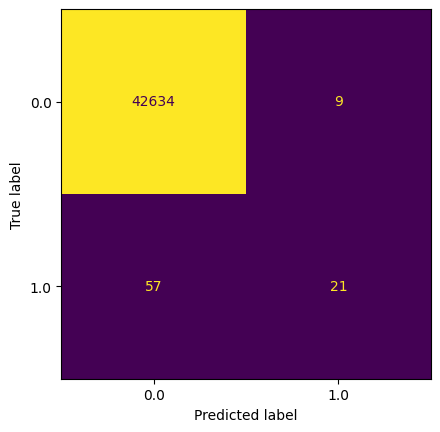

In [8]:
#KNN
base_knn = cuml.KNeighborsClassifier()
param_grid = {
    'n_neighbors':np.arange(1,50, 5),
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan','minkowski']
}
grid_model_3 = GridSearchCV(base_knn,param_grid, verbose=1, cv=2)
knn = train_test_model(grid_model_3,train_features,train_labels,val_features,val_labels, title = './outputs/kNN/KNN_CV')

Fitting 2 folds for each of 9 candidates, totalling 18 fits
Test size: 42721
Model Accuracy:  0.993
Total Precision:  0.154
Total Recall:  0.641
Total F1 Score:  0.248
Log loss:  0.256
Confusion Matrix:



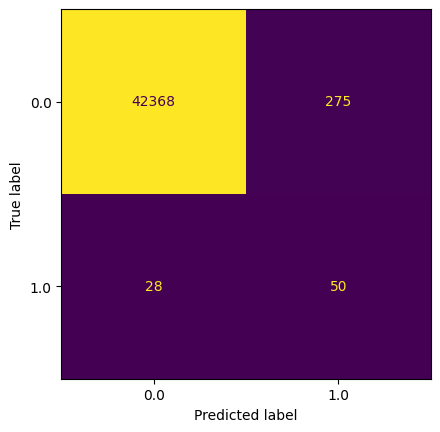

In [14]:
#GNBayes
base_gnb = GaussianNB()#cuml.naive_bayes.GaussianNB()
param_grid = {
    'var_smoothing':np.logspace(-11,-9, 9)
}
grid_model_4 = GridSearchCV(base_gnb,param_grid, verbose=1, cv=2)
gnb = train_test_model(grid_model_4,train_features,train_labels,val_features,val_labels, title = './outputs/GNB/GNB_CV')

In [16]:
import dask_ml.model_selection as dcv

Fitting 2 folds for each of 36 candidates, totalling 72 fits
Test size: 42721
Model Accuracy:  0.998
Total Precision:  1.0
Total Recall:  0.013
Total F1 Score:  0.025
Log loss:  0.065
Confusion Matrix:



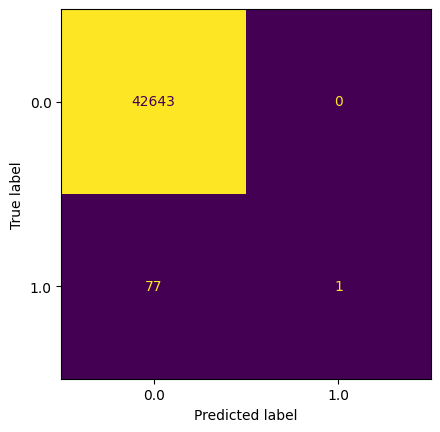

In [19]:
#MLP
base_mlp = MLPClassifier()
param_grid = {
    'hidden_layer_sizes':[(10), (100,), (10,20),],
    'activation':['identity', 'logistic', 'tanh', 'relu'],
    'solver':['lbfgs', 'sgd', 'adam']
}
grid_model_5 = GridSearchCV(base_mlp,param_grid, verbose=1, cv=2)
mlp = train_test_model(grid_model_5,train_features,train_labels,val_features,val_labels, title = './outputs/MLP/MLP_CV')

Fitting 2 folds for each of 20 candidates, totalling 40 fits
Test size: 42721
Model Accuracy:  0.999
Total Precision:  0.899
Total Recall:  0.795
Total F1 Score:  0.844
Log loss:  0.019
Confusion Matrix:



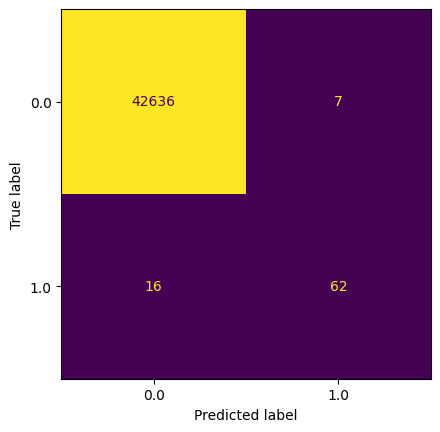

In [30]:
#DT
base_dt = DecisionTreeClassifier()
param_grid = {
    'criterion':['gini','entropy'],
    'max_depth':np.arange(1,50,5),
}
grid_model_6 = GridSearchCV(base_dt,param_grid, verbose=1, cv=2)
dt = train_test_model(grid_model_6,train_features,train_labels,val_features,val_labels, title = './outputs/Dtree/DT_CV')

In [25]:
f_train = np.concatenate((train_features, val_features), axis=0)
l_train = np.concatenate((train_labels, val_labels), axis=0)

In [26]:
#Undersampling
rus = under_sampling.RandomUnderSampler()
train_ud, train_labels_ud = rus.fit_resample(f_train, l_train)
#Oversampling
ros = over_sampling.RandomOverSampler()
train_os, train_labels_os = ros.fit_resample(f_train, l_train)
#SMOTE
smote = over_sampling.SMOTE()
train_sm, train_labels_sm = smote.fit_resample(f_train, l_train)

Test size: 42722
Model Accuracy:  0.998
Total Precision:  0.071
Total Recall:  0.044
Total F1 Score:  0.055
Log loss:  0.088
Confusion Matrix:



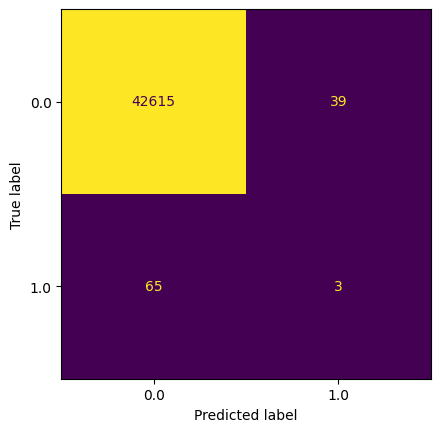

Test size: 42722
Model Accuracy:  0.999
Total Precision:  0.837
Total Recall:  0.529
Total F1 Score:  0.649
Log loss:  0.033
Confusion Matrix:



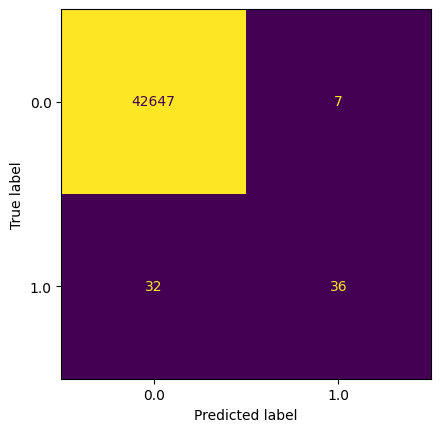

Test size: 42722
Model Accuracy:  0.999
Total Precision:  0.692
Total Recall:  0.265
Total F1 Score:  0.383
Log loss:  0.049
Confusion Matrix:



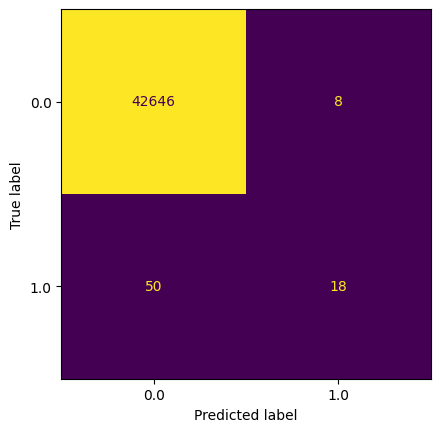

Test size: 42722
Model Accuracy:  0.999
Total Precision:  0.7
Total Recall:  0.412
Total F1 Score:  0.519
Log loss:  0.044
Confusion Matrix:



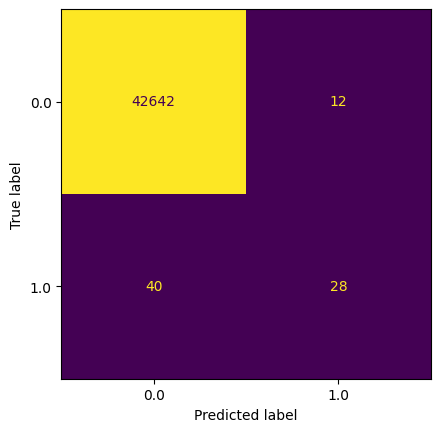

Test size: 42722
Model Accuracy:  0.99
Total Precision:  0.118
Total Recall:  0.853
Total F1 Score:  0.207
Log loss:  0.375
Confusion Matrix:



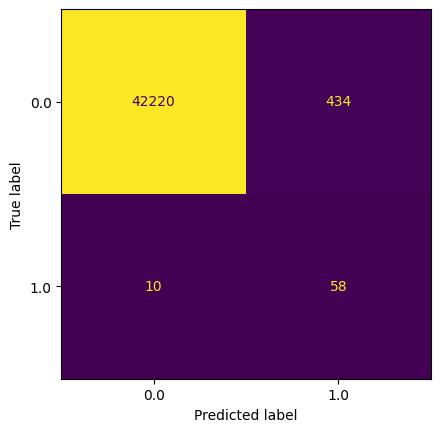

Test size: 42722
Model Accuracy:  0.999
Total Precision:  0.881
Total Recall:  0.765
Total F1 Score:  0.819
Log loss:  0.019
Confusion Matrix:



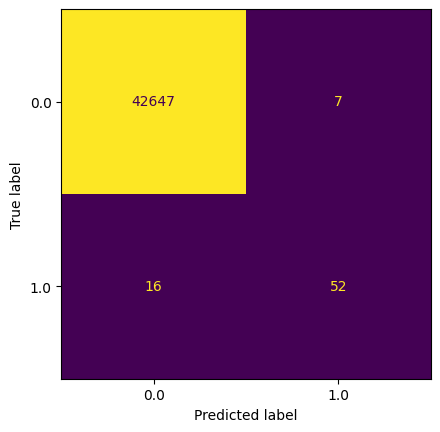

In [31]:
val1 = train_test_model(grid_model_1.best_estimator_,train_ud,train_labels_ud,test_features,test_labels, title = './outputs/SVM/SVM_CV')
val2 = train_test_model(BaggingClassifier(grid_model_2.best_estimator_), f_train, l_train, test_features,test_labels, title = './outputs/LogisticRegression/LGR_CV')
val3 = train_test_model(grid_model_3.best_estimator_, train_os, train_labels_os, test_features,test_labels, title = './outputs/kNN/KNN_CV')
val4 = train_test_model(AdaBoostClassifier(grid_model_4.best_estimator_), f_train, l_train, test_features,test_labels, title = './outputs/GNB/GNB_CV')
val5 = train_test_model(grid_model_5.best_estimator_, train_sm, train_labels_sm, test_features,test_labels, title = './outputs/MLP/MLP_CV')
val6 = train_test_model(BaggingClassifier(grid_model_6.best_estimator_), f_train, l_train, test_features,test_labels, title = './outputs/Dtree/DT_CV')

In [42]:
pd.DataFrame(np.vstack([val1, val2, val3, val4, val5, val6]), columns=['Accuracy', 'Precision', 'Recall', 'NPV', 'FPR', 'TNR', 'FNR', 'FDR', 'F1', 'LogLoss'], index=['SVM Classifier', 'Logistic Regression', 'kNN Classifier', 'Naive Bayes Classifier', 'Multi-Layer Perceptron', 'Decision Trees']).T.round(3).to_clipboard()#.to_latex('./outputs/final.tex')#.to_csv('./outputs/summary.csv')

In [41]:
grid_model_6.best_params_

{'criterion': 'gini', 'max_depth': 6}